## COVID Vaccinations Forecast

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics

### Load data and clean

In [5]:
vaccinations = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv', parse_dates= ['date'])
#or, if the site is no longer active, use this file downloaded 4/22/2021
#vaccinations = pd.read_excel('us_state_vaccinations.xlsx', parse_dates= ['date'])
#
vaccinations_clean = vaccinations.dropna(axis= 'index', subset= ['people_fully_vaccinated']).copy()
#
vaccinations_clean['week'] = vaccinations_clean['date'].dt.week

#Optional: filter by date and/or location

#month = 4
#vaccinations_clean = vaccinations_clean.loc[vaccinations_clean['date'].dt.month <= month].copy()

#state = 'California'
#vaccinations_clean = vaccinations_clean.loc[vaccinations_clean['location'] == state].copy()

### Aggregate to weekly vaccinations

In [6]:
weekly_vaccinations_by_state = vaccinations_clean.groupby(['location', 'week'])[['people_fully_vaccinated']].max().reset_index()
#
weekly_vaccinations_total = weekly_vaccinations_by_state.groupby(['week'])[['people_fully_vaccinated']].sum().reset_index()
#drop most recent week - contains incomplete data
weekly_vaccinations_total.drop(weekly_vaccinations_total.tail(1).index, inplace= True)

### Incremental vaccinations/week

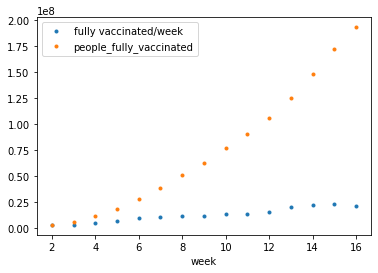

In [15]:
weekly_vaccinations_total['vaccinated_shift1'] = weekly_vaccinations_total['people_fully_vaccinated'].shift(1).fillna(0)
#
weekly_vaccinations_total['fully vaccinated/week'] = weekly_vaccinations_total['people_fully_vaccinated'] - weekly_vaccinations_total['vaccinated_shift1']
#
weekly_vaccinations_total = weekly_vaccinations_total.drop(columns= ['vaccinated_shift1'])
#plot vaccinations
weekly_vaccinations_total.plot(x= 'week', y= ['fully vaccinated/week', 'people_fully_vaccinated'], style= '.')

### Set up regression analysis

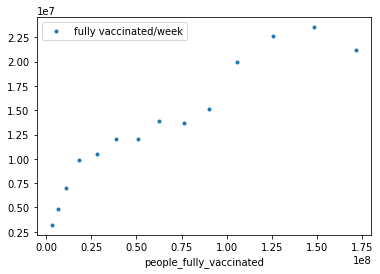

In [17]:
weekly_vaccinations_regres = weekly_vaccinations_total.copy()
#shift cumulative vaccinations
weekly_vaccinations_regres['people_fully_vaccinated'] = weekly_vaccinations_regres['people_fully_vaccinated'].shift(1).fillna(0)
#add (cumulative vaccinations)^2
weekly_vaccinations_regres['people_fully_vaccinated^2'] = weekly_vaccinations_regres['people_fully_vaccinated']**2
#remove first row of vaccinations, where shifted cumulative is 0
weekly_vaccinations_regres = weekly_vaccinations_regres.loc['1':, ].copy()
#plot incremental vaccinations
weekly_vaccinations_regres.plot(x= 'people_fully_vaccinated', y= 'fully vaccinated/week', style= '.')

### Regression analysis

In [18]:
#define target variable y
y = weekly_vaccinations_regres['fully vaccinated/week']
#define training data as x_train: people vaccinated, people vaccinated^2
x_train = weekly_vaccinations_regres[['people_fully_vaccinated', 'people_fully_vaccinated^2']]
#using sklearn
model = linear_model.LinearRegression()
model_fit = model.fit(x_train, y)
predict = model.predict(x_train)
#
a = model.intercept_
#
b = model_fit.coef_[0]
c = model_fit.coef_[1]
#
r2 = metrics.r2_score(y, predict)

### Estimate Bass parameters using regression coefficients and population (m)

In [19]:
US_pop = 328200000
#CA_pop = 39510000
#
m = US_pop
p = a / m
q = b + p

### Forecast incremental vaccinations / week

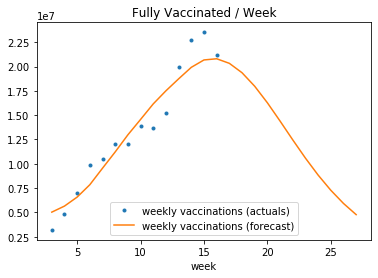

In [43]:
vaccinations_forecast = pd.DataFrame()
vaccinations_forecast['weekly vaccinations (actuals)'], vaccinations_forecast['cumulative vaccinations lagged'] = weekly_vaccinations_regres['fully vaccinated/week'] , weekly_vaccinations_regres['people_fully_vaccinated'] 
#add week number
vaccinations_forecast['week'] = weekly_vaccinations_total['week'].loc[1:]
#forecast new adoptions
def bass_forecast(cumulative_series):
    #Bass forecast equation:
    # s(t) = pm + qS(t) - (q/m)S(t)^2
    #s is incremental vaccinations
    #S is cumulative lagged vaccinations
    return p*m + q*cumulative_series - (q / m) * cumulative_series**2
vaccinations_forecast['weekly vaccinations (forecast)'] = bass_forecast(vaccinations_forecast['cumulative vaccinations lagged'])
#plot forecasted values vs actuals (backcast check)
#vaccinations_forecast.plot(x = 'week', y = ['weekly vaccinations (actuals)', 'weekly vaccinations (forecast)'], style= {'weekly vaccinations (actuals)':'.', 'weekly vaccinations (forecast)':'-'})

#forecast next period from actual cumulative vaccinations
new_row = vaccinations_forecast.iloc[-1:,].copy()
new_row.index += 1
new_row['week'] += 1
new_row['cumulative vaccinations lagged'] = new_row['weekly vaccinations (actuals)'] + new_row['cumulative vaccinations lagged']
new_row['weekly vaccinations (actuals)'] = np.NaN
new_row['weekly vaccinations (forecast)'] = bass_forecast(new_row['cumulative vaccinations lagged'])
vaccinations_forecast = vaccinations_forecast.append(new_row)
#forecast next X periods from cumulative vaccinations
periods = 10
#
for i in range(periods):
    next_period = vaccinations_forecast.iloc[-1:,].copy()
    next_period.index += 1
    next_period['week'] += 1
    next_period['cumulative vaccinations lagged'] = next_period['weekly vaccinations (forecast)'] + next_period['cumulative vaccinations lagged']
    next_period['weekly vaccinations (actuals)'] = np.NaN
    next_period['weekly vaccinations (forecast)'] = bass_forecast(next_period['cumulative vaccinations lagged'])
    vaccinations_forecast = vaccinations_forecast.append(next_period)
#save outputs to chart and table
plot = vaccinations_forecast.plot(x = 'week', y = ['weekly vaccinations (actuals)', 'weekly vaccinations (forecast)'], style= {'weekly vaccinations (actuals)':'.', 'weekly vaccinations (forecast)':'-'}, title= 'Fully Vaccinated / Week')
plot.get_figure().savefig('vaccinations_forecast.png')
#final forecast table
vaccinations_forecast_table = vaccinations_forecast.copy()
#new series to match incrementals and cumulative to same period
vaccinations_forecast_table['cumulative weekly vaccinations'] = vaccinations_forecast_table['weekly vaccinations (actuals)'] + vaccinations_forecast_table['cumulative vaccinations lagged']
#fill in forecast values where cumulative (actuals) are missing
vaccinations_forecast_table.loc[vaccinations_forecast_table['weekly vaccinations (actuals)'].isna(), 'cumulative weekly vaccinations'] = vaccinations_forecast_table['weekly vaccinations (forecast)'] + vaccinations_forecast_table['cumulative vaccinations lagged']
#reduce table
vaccinations_forecast_table.index = vaccinations_forecast_table['week']
vaccinations_forecast_table = vaccinations_forecast_table[['weekly vaccinations (actuals)', 'weekly vaccinations (forecast)', 'cumulative weekly vaccinations']].copy()
vaccinations_forecast_table.to_csv('weekly_vaccinations_forecast.csv')